In [1]:
from pathlib import Path
from typing import Literal
import zipfile

import cdsapi
import geopandas as gpd
import imageio.v2 as imageio
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import subprocess
import xarray as xr

from common import set_plot_style, load_font

In [2]:
fetch_data = False

ROOT_FOLDER = Path().resolve()
DATA_FOLDER = ROOT_FOLDER / "data"
assert DATA_FOLDER.exists()
NETCDF_FOLDER = DATA_FOLDER / "Temperature"
OUTPUT_FOLDER = ROOT_FOLDER / "output"

lat_min, lat_max = 35, 47
lon_min, lon_max = 5, 20

scenarios = ["historical", "ssp1_2_6", "ssp2_4_5", "ssp3_7_0", "ssp4_6_0", "ssp5_8_5"]
projections_nicknames = {
    "ssp1_2_6": "Sviluppo sostenibile",
    "ssp2_4_5": "Metà strada",
    "ssp3_7_0": "Rivalità regionali",
    "ssp4_6_0": "Diseguaglianza",
    "ssp5_8_5": "Sviluppo basato sui comb. fossili",
}

countries_vectorial = Path(
    DATA_FOLDER / "countries_boundaries" / "CNTR_BN_10M_2020_4326.geojson"
)
countries_name = Path(DATA_FOLDER / "countries_boundaries" / "CNTR_AT_2020.csv")

images_dir = Path(OUTPUT_FOLDER / "images" / "temperature")

gif_dir = Path(OUTPUT_FOLDER / "gif" / "temperature")

In [3]:
# initialization
NETCDF_FOLDER.mkdir(parents=True, exist_ok=True)
gif_dir.mkdir(parents=True, exist_ok=True)
images_dir.mkdir(parents=True, exist_ok=True)

client = cdsapi.Client()

region_bbox = [lat_max, lon_min, lat_min, lon_max]

parallel = Parallel(n_jobs=-1, verbose=10)

set_plot_style()
load_font()

2025-05-17 14:26:37,417 WARNING [2025-05-15T00:00:00] Scheduled maintenance of the Data Stores Cloud Infrastructure - 19 May 2025. Please follow status [here](https://status.ecmwf.int/) or in our [forum](https://forum.ecmwf.int/t/scheduled-maintenance-of-the-data-stores-cloud-infrastructure-19-may-2025/13056/1)
2025-05-17 14:26:37,418 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-05-17 14:26:37,419 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.


## Get historical and projected temperature for all SSPs

In [4]:
def fetch_cmip6_data(scenario: str, output_folder: Path = NETCDF_FOLDER) -> Path:
    dataset = "projections-cmip6"
    match scenario:
        case "historical":
            years = list(str(year) for year in range(1950, 2015))
        case "ssp1_2_6" | "ssp2_4_5" | "ssp3_7_0" | "ssp4_6_0" | "ssp5_8_5":
            years = list(str(year) for year in range(2015, 2100))

    request = {
        "temporal_resolution": "monthly",
        "experiment": scenario,
        "variable": "surface_temperature",
        "model": "mri_esm2_0",  # 100km res
        # "model": "cnrm_esm2_1",
        "month": list(f"{month:02d}" for month in range(1, 13)),
        "year": years,
        "area": region_bbox,
    }
    output_zip_filepath = output_folder / f"{scenario}.zip"

    client.retrieve(dataset, request).download(output_zip_filepath)

    return output_zip_filepath

In [5]:
# beware, it can take some minutes!
zip_filepaths = {}
if fetch_data:
    for scenario in scenarios:
        zip_filepaths[scenario] = fetch_cmip6_data(scenario)

else:
    for scenario in scenarios:
        zip_filepaths[scenario] = list(NETCDF_FOLDER.glob(f"{scenario}.zip"))[0]

In [6]:
def unzip_single_netcdf(
    zip_filepath: Path, output_folder: Path = NETCDF_FOLDER
) -> Path:
    # unzip the netCDF file in the zip file
    # there should be only one netCDF in the zip
    with zipfile.ZipFile(zip_filepath, "r") as zip_ref:
        zipped_files = zip_ref.namelist()
        netcdf_files = [file for file in zipped_files if file.endswith(".nc")]
        if len(netcdf_files) != 1:
            raise ValueError(f"Expected 1 netCDF file, got {len(netcdf_files)}")
        netcdf_file = netcdf_files[0]
        zip_ref.extract(netcdf_file, output_folder)
        print(f"Extracted {output_folder / netcdf_file}")
        return output_folder / netcdf_file

In [7]:
# unzip all the zip files in the folder
nc_filepaths = {}
for scenario in scenarios:
    nc_filepaths[scenario] = unzip_single_netcdf(zip_filepaths[scenario])

Extracted /home/robin/projects/PyConIT2025/data/Temperature/ts_Amon_MRI-ESM2-0_historical_r1i1p1f1_gn_19500116-20141216.nc
Extracted /home/robin/projects/PyConIT2025/data/Temperature/ts_Amon_MRI-ESM2-0_ssp126_r1i1p1f1_gn_20150116-20991216.nc
Extracted /home/robin/projects/PyConIT2025/data/Temperature/ts_Amon_MRI-ESM2-0_ssp245_r1i1p1f1_gn_20150116-20991216.nc
Extracted /home/robin/projects/PyConIT2025/data/Temperature/ts_Amon_MRI-ESM2-0_ssp370_r1i1p1f1_gn_20150116-20991216.nc
Extracted /home/robin/projects/PyConIT2025/data/Temperature/ts_Amon_MRI-ESM2-0_ssp460_r1i1p1f1_gn_20150116-20991216.nc
Extracted /home/robin/projects/PyConIT2025/data/Temperature/ts_Amon_MRI-ESM2-0_ssp585_r1i1p1f1_gn_20150116-20991216.nc


In [8]:
# concatenate historical with every scenario
# also, compute mean yearly temperature
ds_hist = xr.open_dataset(nc_filepaths["historical"])
da_hist = ds_hist.ts
da_hist = da_hist.groupby("time.year").mean()

projections = [scenario for scenario in scenarios if scenario != "historical"]

das = {}
for scenario in projections:
    ds_scenario = xr.open_dataset(nc_filepaths[scenario])
    da_scenario = ds_scenario.ts
    da_scenario = da_scenario.groupby("time.year").mean()
    das[scenario] = xr.concat([da_hist, da_scenario], dim="year").sortby("year")

In [9]:
# create a single dataarray with all the scenarios (new dimension)
temp = xr.concat(das.values(), gpd.pd.Index(das.keys(), name="scenario"))

In [10]:
# convert kelvin to celsius
temp = temp - 273.15

## Plot them and create a nice GIF

In [11]:
# get the minimum and maximum temperature among every scenario
vmin, vmax = temp.min().values, temp.max().values
vmin = 10  # override minimum vmin to improve the plots
print(f"vmin: {vmin}, vmax: {vmax}")

vmin: 10, vmax: 25.24383544921875


In [12]:
# Load world map data
world = gpd.read_file(countries_vectorial)
world_names = gpd.pd.read_csv(countries_name)
world = world.join(world_names.set_index("CNTR_ID"), on="CNTR_CODE", how="left")

# Filter for Mediterranean countries
mediterranean_countries = [
    "Spain",
    "France",
    "Italy",
    "Slovenia",
    "Croatia",
    "Bosnia and Herzegovina",
    "Montenegro",
    "Albania",
    "Greece",
    "Turkey",
    "Syria",
    "Lebanon",
    "Israel",
    "Egypt",
    "Libya",
    "Tunisia",
    "Algeria",
    "Morocco",
]
mediterranean = world[world["NAME_ENGL"].isin(mediterranean_countries)]

In [13]:
def plot_single_year(
    dataarray: xr.DataArray,
    year: int,
    scenario: Literal[projections],
    output_folder: Path = images_dir,
) -> Path:
    # load again the plot params as they seem to be ignored in Parallel
    set_plot_style()
    load_font()

    fig, ax = plt.subplots(figsize=(5, 5))
    mediterranean.plot(ax=ax, color="black", zorder=5, linewidth=0.5)

    dataarray.sel(scenario=scenario, year=year).plot(
        cmap="Reds",
        ax=ax,
        vmin=vmin,
        vmax=vmax,
        cbar_kwargs={"label": ("Temperatura media annuale (°C)")},
    )
    ax.set_xlim(lon_min, lon_max)
    ax.set_ylim(lat_min, lat_max)
    ax.tick_params(axis="both", which="major", labelsize="xx-small")
    ax.set_xlabel("Longitudine", fontsize="small")
    ax.set_ylabel("Latitudine", fontsize="small")
    ax.set_title(f"Anno {str(year)[:4]}\n{projections_nicknames[scenario]}")

    # Save the plot locally
    filename = output_folder / f"{scenario}_{str(year)[:4]}.png"
    plt.savefig(filename, format="png")
    plt.close(fig)

    return filename

In [14]:
print("Plotting the temperature...")

images_filepaths = {scenario: [] for scenario in projections}
for scenario in temp.scenario.values:
    print(scenario)
    images_filepaths[scenario] = list(
        parallel(
            delayed(plot_single_year)(dataarray=temp, year=year, scenario=scenario)
            for year in temp.sel(scenario=scenario).year.values
            if year > 2050
        )
    )

print("Done! Reading the images...")
images = {
    scenario: [imageio.imread(image_filepath) for image_filepath in paths]
    for scenario, paths in images_filepaths.items()
}

# crop out the colorbar
images_nocb = {
    scenario: [image[:, :1550, :] for image in images[scenario]]
    for scenario, image in images.items()
}
print("Images in memory ✅")

Plotting the temperature...
ssp1_2_6


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  39 out of  49 | elapsed:    6.3s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  44 out of  49 | elapsed:    6.8s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  49 out of  49 | elapsed:    6.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


ssp2_4_5


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  39 out of  49 | elapsed:    4.4s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  44 out of  49 | elapsed:    4.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  49 out of  49 | elapsed:    5.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


ssp3_7_0


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  39 out of  49 | elapsed:    4.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  44 out of  49 | elapsed:    4.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  49 out of  49 | elapsed:    5.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


ssp4_6_0


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  39 out of  49 | elapsed:    3.5s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  44 out of  49 | elapsed:    4.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  49 out of  49 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


ssp5_8_5


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  39 out of  49 | elapsed:    3.7s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  44 out of  49 | elapsed:    4.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  49 out of  49 | elapsed:    4.7s finished


Done! Reading the images...
Images in memory ✅


In [15]:
# Create and save the GIF
print("Creating the gifs...")

gif_filepaths = {scenario: gif_dir / f"{scenario}.gif" for scenario in projections}
gif_nocb_filepaths = {
    scenario: gif_dir / f"{scenario}_nocb.gif" for scenario in projections
}

_ = parallel(
    delayed(imageio.mimwrite)(
        (gif_filepaths[scenario] if keep_colorbar else gif_nocb_filepaths[scenario]),
        images[scenario] if keep_colorbar else images_nocb[scenario],
        fps=4,
    )
    for scenario in projections
    for keep_colorbar in [True, False]
)

Creating the gifs...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   15.8s remaining:   36.9s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   16.7s remaining:   16.7s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   18.2s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   21.3s finished


In [16]:
# reduce the size of the gifs
_ = parallel(
    delayed(subprocess.run)(
        f"gifsicle --colors 64 -O3 {gif_path} -o {gif_path.with_stem(gif_path.stem + '_optim')}",
        shell=True,
        check=True,
    )
    for gif_path in list(gif_filepaths.values()) + list(gif_nocb_filepaths.values())
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    6.4s remaining:   15.0s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    8.7s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    8.8s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   11.1s finished


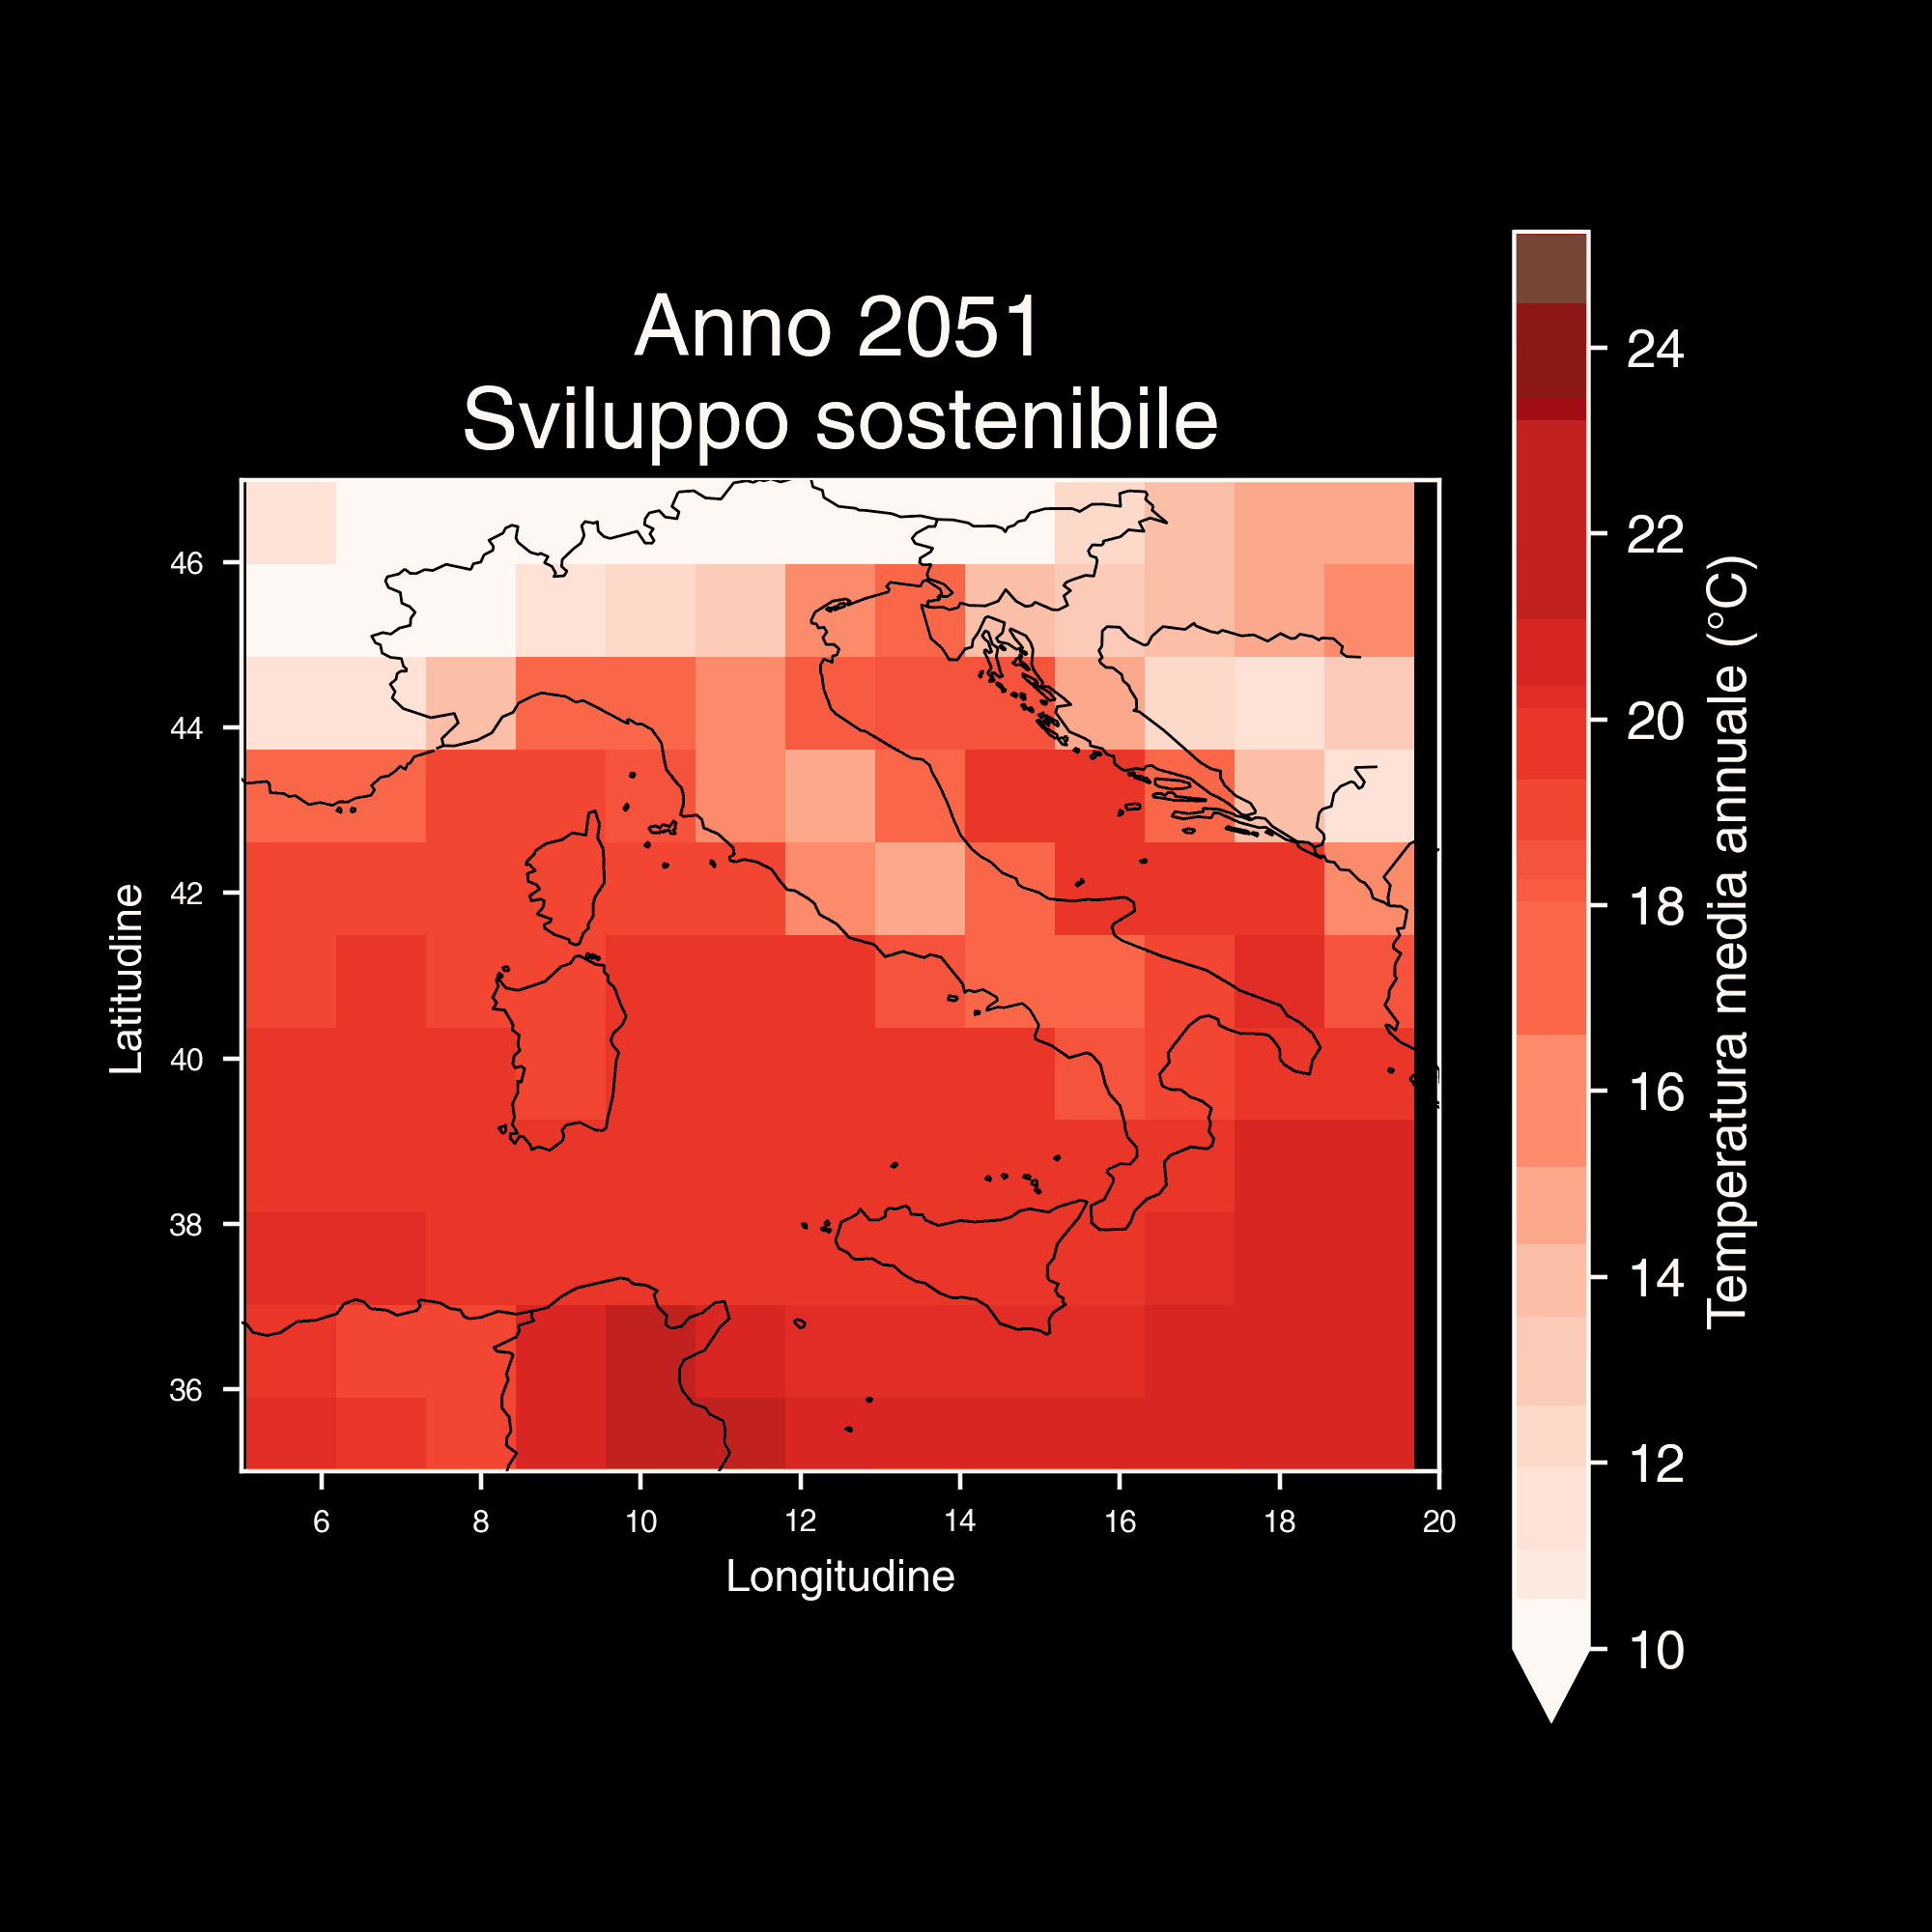

In [17]:
# Display the GIF
from IPython.display import Image

Image(filename=gif_dir / f"{projections[0]}_optim.gif")